In [1]:
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

In [4]:
#sc_out = pd.DataFrame()
#for file in os.listdir('../ce_data/StatCache'):
#    x = pd.read_csv("../ce_data/StatCache/"+file)
#    x['id'] = x.index
#    x['id'] = x['id'].apply(lambda x: file[:-4] + "_" + str(x))
#    sc_out = pd.concat([x, sc_out], ignore_index=True)
#sc_out = sc_out.sort_values("id", ascending=True, ignore_index=True).fillna(0)
sc_out = pd.read_csv('../ce_data/output_512/statcache_512_nowb.csv')
for i in ['32','64','128','256','512','1024','2048','4096','8192']:
    sc_out['lru_'+i] = sc_out['lru_'+i]/sc_out['total_accesses']
print(sc_out)

                         id  random_32    lru_32  random_64    lru_64  \
0       400.perlbench-41B_0   0.004097  0.002922   0.002877  0.002121   
1     400.perlbench-41B_436   0.018865  0.013493   0.012396  0.008749   
2       400.perlbench-50B_0   0.004524  0.002858   0.002693  0.001779   
3          401.bzip2-226B_0   0.057553  0.048776   0.044189  0.035407   
4         401.bzip2-226B_54   0.095998  0.086282   0.078118  0.069222   
...                     ...        ...       ...        ...       ...   
6182     657.xz_s-3167B_466   0.038392  0.028100   0.027225  0.020199   
6183     657.xz_s-3167B_574   0.042664  0.035252   0.030093  0.022492   
6184       657.xz_s-4994B_0   0.008552  0.006117   0.005317  0.003739   
6185     657.xz_s-4994B_343   0.011664  0.008041   0.007941  0.005771   
6186         657.xz_s-56B_0   0.000000  0.000000   0.000000  0.000000   

      random_128   lru_128  random_256   lru_256  random_512   lru_512  \
0       0.002266  0.001816    0.001900  0.001627 

In [5]:
cache_misses = pd.read_csv("../ce_data/output_512/dataset.csv")
l = ['mcf' in i for i in sc_out["id"]]
for i in ['1024', '2048', '4096', '8192']:
    cache_misses[i] =  cache_misses['misses_'+i] / cache_misses['accesses_'+i]
cache_misses = cache_misses[l]
sc_out = sc_out[l]
print(cache_misses, sc_out)

                      id       0        1        2        3       4       5  \
247       429.mcf-184B_0   28880   249616    24512    16000   11776    8544   
248       429.mcf-184B_3   59088   222192    29120    23984   28992   24112   
249       429.mcf-184B_6   71792   257760    28128    30240   31808   29120   
250       429.mcf-184B_9   33744   262272    23376    19968   14368    9936   
251      429.mcf-184B_12   78976   230272    33984    34400   34528   30928   
...                  ...     ...      ...      ...      ...     ...     ...   
4701  605.mcf_s-994B_694  563152   930768   867392   981936  722752  569056   
4702  605.mcf_s-994B_709  402256   612304   582608   680640  481952  344416   
4703  605.mcf_s-994B_719  693408  1104928  1108576  1262208  834416  621600   
4704  605.mcf_s-994B_737  215792   431648   669200   712848  313120  147376   
4705  605.mcf_s-994B_743  217232   434432   661456   721664  321504  155408   

           6       7       8  ...  accesses_2048  m

In [6]:
# Little check
d = {}
for i,j in zip(cache_misses["id"], sc_out["id"]):
    if i != j:
        print(i)
    if i in d: 
        print(i)
    d[i]=1

In [7]:
from sklearn.metrics import mean_squared_error
bdf = pd.DataFrame()
for i in ['1024', '2048', '4096', '8192']:
    tmp = sc_out['lru_'+i] / sc_out['lru_512']
    # This drops na
    cms = cache_misses[tmp <= 1]
    tmp = tmp[tmp <= 1]
    c_acc_lru = mean_squared_error(tmp, cms[i])
    #c_acc_rand = mean_squared_error(o['random_'+i], cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')
    bdf['sc_'+i] = tmp
    bdf['cm_'+i] = cms[i]
    bdf['diffs_'+i] = abs(tmp - cms[i])

Cache size 1024	: lru_mse = 0.042543842357392
Cache size 2048	: lru_mse = 0.09009046707490777
Cache size 4096	: lru_mse = 0.08669883047806365
Cache size 8192	: lru_mse = 0.05870097737436593


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in ['1024','2048','4096','8192']:
    tmp = sc_out['lru_'+i] * cache_misses['l1d_accesses_'+i]/cache_misses['accesses_'+i]
    
    c_acc_lru = mean_squared_error(tmp, cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')

ValueError: Input contains NaN.

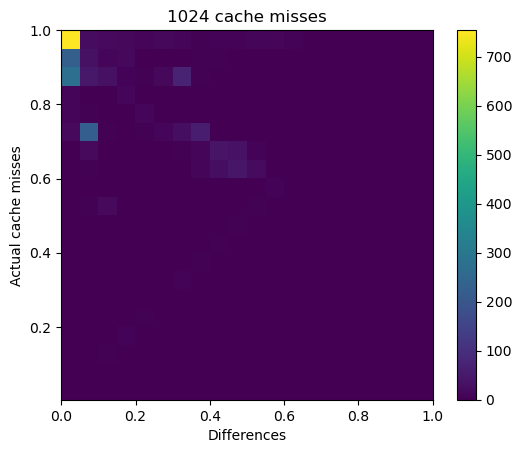

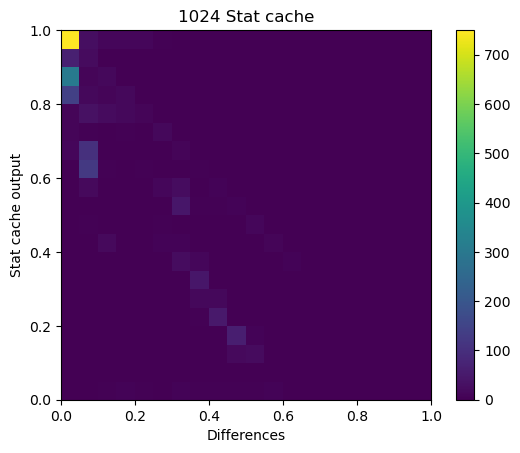

In [9]:
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'], bdf['cm_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 cache misses')
plt.xlabel('Differences')
plt.ylabel('Actual cache misses')
plt.show()
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'],  bdf['sc_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 Stat cache')
plt.ylabel('Stat cache output')
plt.xlabel('Differences')
plt.show()

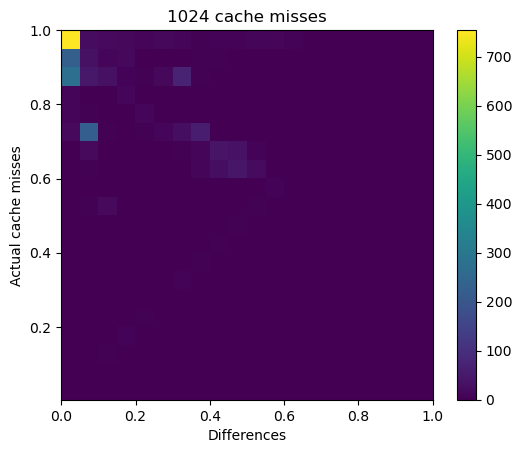

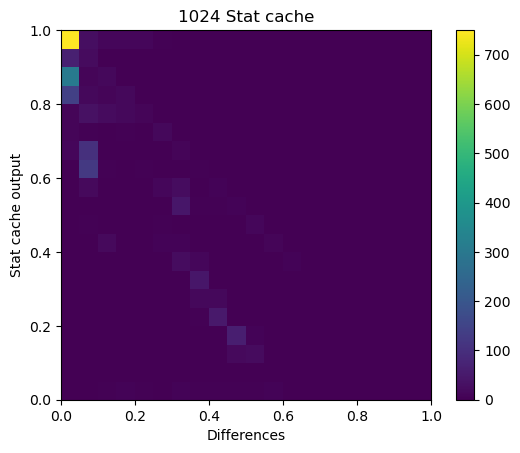

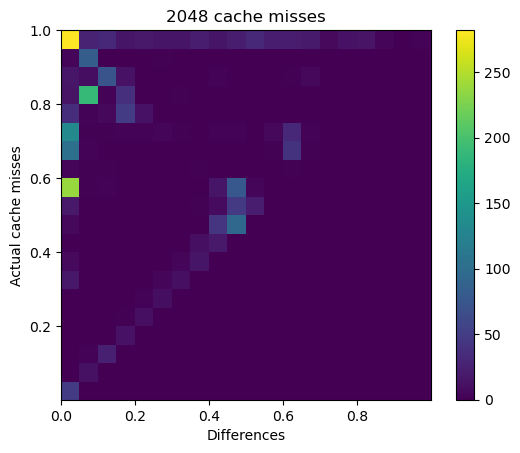

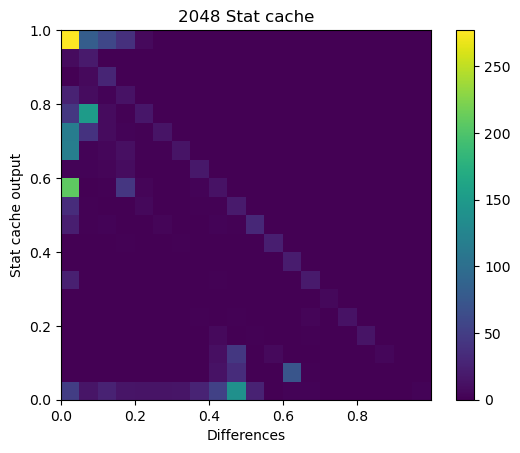

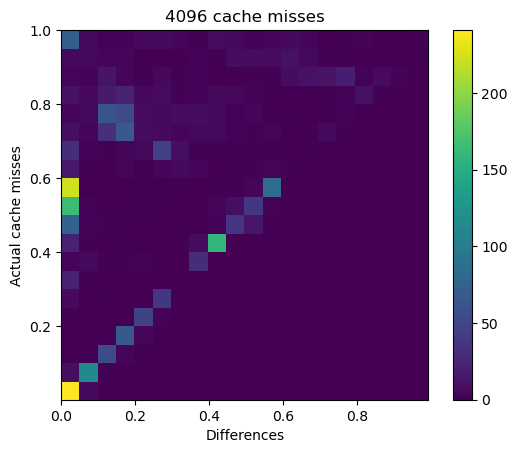

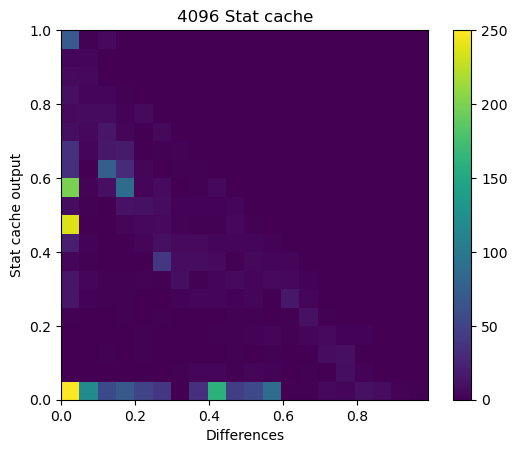

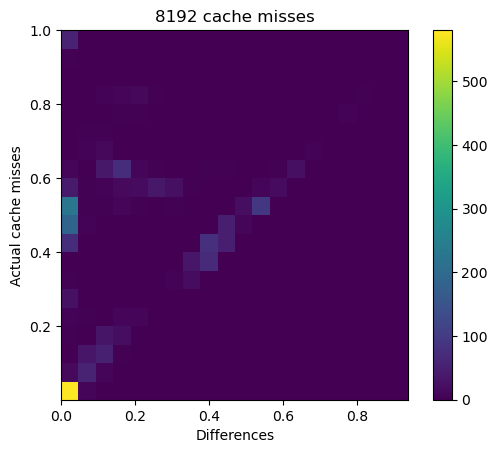

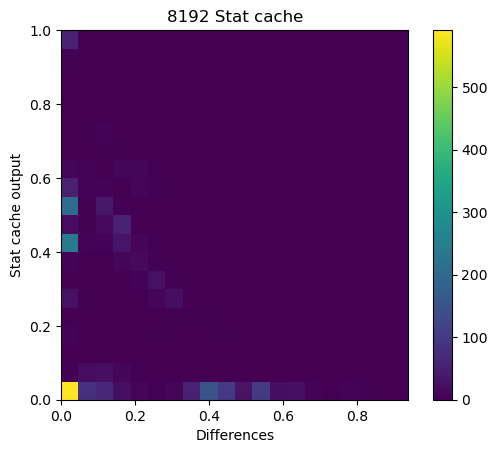

In [10]:
for i in ['1024','2048','4096','8192']:
    heatmap, xedges, yedges = np.histogram2d(bdf['diffs_'+i], bdf['cm_'+i], bins=20)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.colorbar()
    plt.title(i+' cache misses')
    plt.xlabel('Differences')
    plt.ylabel('Actual cache misses')
    plt.show()
    heatmap, xedges, yedges = np.histogram2d(bdf['diffs_'+i],  bdf['sc_'+i], bins=20)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.colorbar()
    plt.title(i+' Stat cache')
    plt.ylabel('Stat cache output')
    plt.xlabel('Differences')
    plt.show()

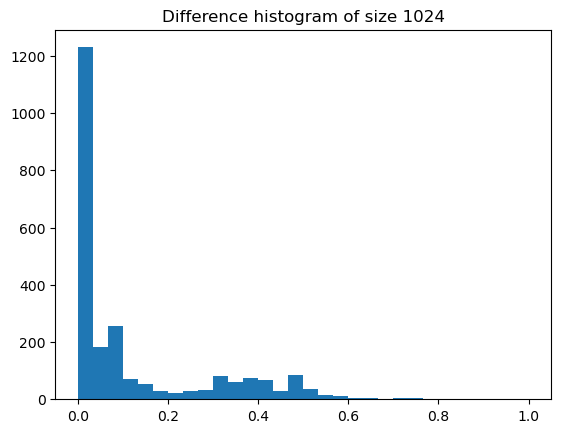

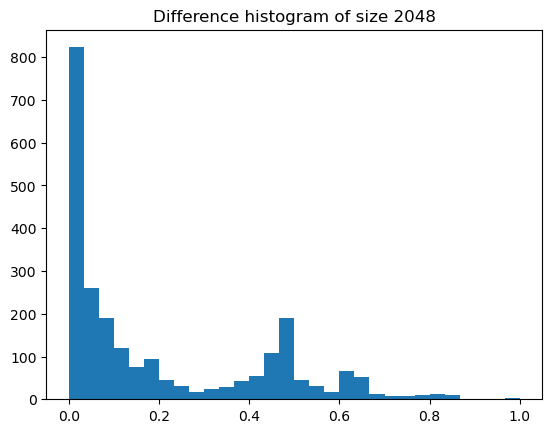

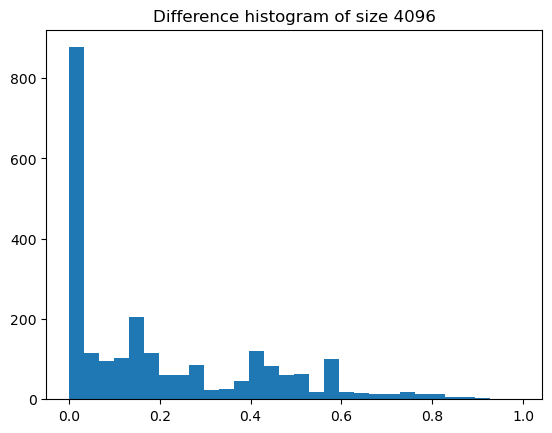

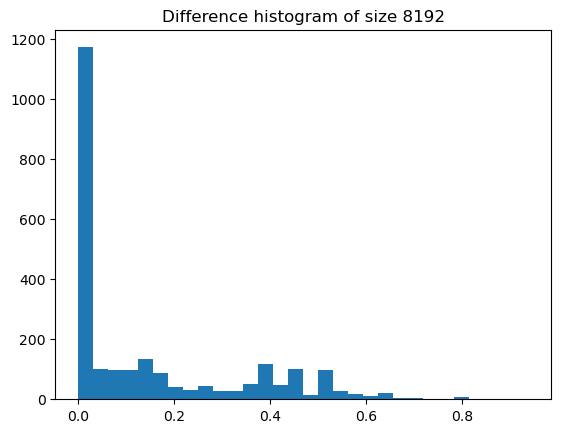

In [11]:
for i in ['1024','2048','4096','8192']:
    plt.title(f"Difference histogram of size {i}")
    plt.hist(bdf['diffs_'+i], bins =30)
    plt.show()

In [33]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error(np.random.random(size=len(cache_misses)), cache_misses[i])
    c_mae_lru = mean_absolute_error(np.random.random(size=len(cache_misses)), cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}, lru_mae = {c_mae_lru}')

Cache size 1024	: lru_mse = 0.16308250444748582, lru_mae = 0.332486921591501
Cache size 2048	: lru_mse = 0.15682810781522402, lru_mae = 0.32258183757010767
Cache size 4096	: lru_mse = 0.1513229210815565, lru_mae = 0.3180058145052438
Cache size 8192	: lru_mse = 0.16625114802709884, lru_mae = 0.33227330792988546


In [41]:
d = {}
for i in sc_out["id"]:
    ctr = 1
    while(1):
        if i[-ctr] == '_':
            break
        ctr+=1
    d[i[:-ctr]] = 1
print(189-len(d.keys()))

32


In [32]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error([0.5]*len(cache_misses), cache_misses[i])
    c_mae_lru = mean_absolute_error([0.5]*len(cache_misses), cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}, lru_mae = {c_mae_lru}')

Cache size 1024	: lru_mse = 0.08470210292056159, lru_mae = 0.2435920741675385
Cache size 2048	: lru_mse = 0.07476705622378711, lru_mae = 0.22368300342597008
Cache size 4096	: lru_mse = 0.0695452021398685, lru_mae = 0.20722643909058383
Cache size 8192	: lru_mse = 0.08611380457377822, lru_mae = 0.2305847153257924


In [ ]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error(bdf[bdf['sc_'+i] < 0.6]['sc_'+i], bdf[bdf['sc_'+i] < 0.6]['cm_'+i])
    c_mae_lru = mean_absolute_error(bdf[bdf['sc_'+i] < 0.6]['sc_'+i], bdf[bdf['sc_'+i] < 0.6]['cm_'+i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}, lru_mae = {c_mae_lru}')

In [ ]:
plt.scatter(bdf['cm_1024'], bdf['diffs_1024'], marker='x', linewidths = 0.3)
plt.show()
plt.scatter(bdf['sc_1024'], bdf['diffs_1024'], marker='x', linewidths = 0.3)
plt.show()